#  Level-Cutoff through Strong Decay

In [69]:
%matplotlib inline

In [1]:
from IPython.parallel import Client
try:
    cluster = Client()[:] # view on all cluster engines
    print "%d engines available" % len(cluster)
except IOError as e:
    print e
    print "\nDid you start any engines?"

3 engines available


In [44]:
from notebook_utils import cutoff_worker

In [81]:
import QDYN
from pandas import DataFrame
from copy import copy

We take into account 4 qubit levels with realistic decay time [Peterer et al, Phys. Rev. Lett. 114, 010501 (2015)], and 5 cavity levels [A. W. Cross and J. M. Gambetta, Phys. Rev. A 91 032325 (2015)]. All remaining levels are set to a decay rate of 10 GHZ (corresponding to 0.1 ns) which effectively throws away any population in the higher levels.

## Does the decay ensure that levels can be cut off?

Our hypothesis is that it is sufficient to include *one* extra level (5th qubit level, 6th cavity) level, to reach convergence w.r.t n_q, n_c, for any possible pulse.

We test this by exploring the worst possible case: resonant driving of the qubits or the cavity.

Note that an earlier attempt using a "cutoff" decay rate of 50 MHz instead of 10 GHz was not sufficient for convergence!

In [90]:
jobs = []
for w_L in [6.0, 6.75, 10.1]:
    for E_0 in [20.0, 50.0, 100.0, 200.0, 500.0]:
        nt = int(w_L * 200 * 100)
        jobs.append((w_L, E_0, nt, 5, 6))
        jobs.append((w_L, E_0, nt, 6, 8))
        jobs.append((w_L, E_0, nt, 7, 9))

In [91]:
cluster.map_async(cutoff_worker, jobs)

<AsyncMapResult: cutoff_worker>

In [99]:
results = cluster.map(cutoff_worker, jobs).result

In [101]:
def tabulate_cutoff(jobs, results):
    jobs_copy = copy(jobs)
    results_copy = copy(results)
    from QDYN.linalg import norm
    table = {}
    print "%27s\t%25s\t%25s" % ('pulse parameters', 'err(nq:5->6,nc:6->8)', 'err(nq:6->7,nc:8->9)')
    while len(jobs_copy) > 0:
        params1 = jobs_copy.pop(0)
        params2 = jobs_copy.pop(0)
        params3 = jobs_copy.pop(0)
        U1 = results_copy.pop(0)
        U2 = results_copy.pop(0)
        U3 = results_copy.pop(0)
        w_L, E_0, nt, __, __ = params1
        label = "wL = %4.1fGHz, E0 = %5.1fMHz" % (w_L, E_0)
        error2 = norm(U1-U2)
        error3 = norm(U2-U3)
        table[label] = (U1, U2, U3, error2, error3)
        print "%s\t%25.16E\t%25.16E" % (label, error2, error3)
    return table

In [102]:
table = tabulate_cutoff(jobs, results)

           pulse parameters	     err(nq:5->6,nc:6->8)	     err(nq:6->7,nc:8->9)
wL =  6.0GHz, E0 =  20.0MHz	   4.0062451167749215E-17	   3.3090784177039762E-17
wL =  6.0GHz, E0 =  50.0MHz	   9.8994949075975646E-17	   3.7416573537003100E-17
wL =  6.0GHz, E0 = 100.0MHz	   1.1224972214009976E-16	   1.0816653803839229E-16
wL =  6.0GHz, E0 = 200.0MHz	   2.4899799217202957E-16	   2.8319604992211923E-16
wL =  6.0GHz, E0 = 500.0MHz	   1.0100495005387845E-11	   7.9586431131720069E-16
wL =  6.8GHz, E0 =  20.0MHz	   4.8774993576269751E-17	   2.2847319313244030E-17
wL =  6.8GHz, E0 =  50.0MHz	   4.2426407060188678E-17	   3.7416574200223053E-17
wL =  6.8GHz, E0 = 100.0MHz	   7.2801099756814860E-17	   7.0000000518622357E-17
wL =  6.8GHz, E0 = 200.0MHz	   1.9235384233364862E-16	   2.9137605034162621E-16
wL =  6.8GHz, E0 = 500.0MHz	   1.4317821422218171E-11	   6.1644140210363847E-16
wL = 10.1GHz, E0 =  20.0MHz	   5.4691177814399148E-04	   0.0000000000000000E+00
wL = 10.1GHz, E0 =  50.0MHz	   6.7209510

In [103]:
U1, U2, U3, error2, error3 = table['wL = 10.1GHz, E0 = 500.0MHz']

In [104]:
QDYN.io.print_matrix(U1)

{ 3.07E-03, 2.99E-03}( 8.12E-06,-2.49E-05)( 6.64E-06,-2.03E-05)(-8.56E-07, 8.02E-07)
( 8.12E-06,-2.49E-05){-1.09E-03,-1.87E-04}( 2.99E-07, 5.57E-06)( 7.87E-06, 4.74E-06)
( 6.64E-06,-2.03E-05)( 2.99E-07, 5.57E-06){-1.41E-03, 2.74E-04}( 9.70E-06, 3.48E-06)
(-8.56E-07, 8.02E-07)( 7.87E-06, 4.74E-06)( 9.70E-06, 3.48E-06){ 3.08E-04,-2.15E-04}


In [105]:
QDYN.io.print_matrix(U2)

{ 3.27E-03, 3.09E-03}( 8.20E-06,-2.59E-05)( 6.71E-06,-2.12E-05)(-8.90E-07, 8.75E-07)
( 8.20E-06,-2.59E-05){-1.16E-03,-1.44E-04}( 1.32E-07, 5.72E-06)( 8.41E-06, 4.66E-06)
( 6.71E-06,-2.12E-05)( 1.32E-07, 5.72E-06){-1.47E-03, 3.49E-04}( 1.02E-05, 3.31E-06)
(-8.90E-07, 8.75E-07)( 8.41E-06, 4.66E-06)( 1.02E-05, 3.31E-06){ 3.05E-04,-2.50E-04}


In [106]:
from QDYN.linalg import norm

In [107]:
U1.F_avg(U2)

4.5047930533830291e-11

In [108]:
U1.closest_unitary().F_avg(U2.closest_unitary())

0.99963580261964413

In [109]:
norm(U1-U2)

0.00026186504438808036

## Is `nt` sufficiently large?

Since we are not using the RWA, we must sample the time grid sufficiently densely to resolve the fast pulse oscillations.

In [96]:
nt_jobs = []
for w_L in [6.75, 10.1]:
    for E_0 in [50.0, 100.0, 500.0]:
        nt1 = int(w_L * 200 * 100)
        nt2 = int(w_L * 200 * 500)
        nt3 = int(w_L * 200 * 1000)
        nt_jobs.append((w_L, E_0, nt1, 5, 6))
        nt_jobs.append((w_L, E_0, nt2, 5, 6))
        nt_jobs.append((w_L, E_0, nt3, 5, 6))

In [98]:
cluster.map_async(cutoff_worker, nt_jobs)

<AsyncMapResult: cutoff_worker>

In [110]:
nt_results = cluster.map(cutoff_worker, nt_jobs).result

In [111]:
def tabulate_nt(nt_jobs, nt_results):
    jobs_copy = copy(nt_jobs)
    results_copy = copy(nt_results)
    from QDYN.linalg import norm
    table = {}
    print "%27s\t%25s\t%25s" % ('pulse parameters', 'err(sampl:100->500)', 'err(sampl:500->1000)')
    while len(jobs_copy) > 0:
        params1 = jobs_copy.pop(0)
        params2 = jobs_copy.pop(0)
        params3 = jobs_copy.pop(0)
        U1 = results_copy.pop(0)
        U2 = results_copy.pop(0)
        U3 = results_copy.pop(0)
        w_L, E_0, nt, __, __ = params1
        label = "wL = %4.1fGHz, E0 = %5.1fMHz" % (w_L, E_0)
        error2 = norm(U1-U2)
        error3 = norm(U2-U3)
        table[label] = (U1, U2, U3, error2, error3)
        print "%s\t%25.16E\t%25.16E" % (label, error2, error3)
    return table

In [112]:
table_nt = tabulate_nt(nt_jobs, nt_results)

           pulse parameters	      err(sampl:100->500)	     err(sampl:500->1000)
wL =  6.8GHz, E0 =  50.0MHz	   1.1615666551730736E-04	   3.6302925271120581E-06
wL =  6.8GHz, E0 = 100.0MHz	   2.9799965616385195E-04	   9.3127203708978428E-06
wL =  6.8GHz, E0 = 500.0MHz	   5.4321460830059733E-03	   1.6976117453564501E-04
wL = 10.1GHz, E0 =  50.0MHz	   1.2348454657691468E-03	   3.8648360731845470E-05
wL = 10.1GHz, E0 = 100.0MHz	   2.2539811350348726E-03	   7.0595554757248491E-05
wL = 10.1GHz, E0 = 500.0MHz	   6.8729156185578426E-05	   2.1571454157389204E-06


In [113]:
U1, U2, U3, error2, error3 = table_nt['wL =  6.8GHz, E0 = 500.0MHz']

In [123]:
U1.F_avg(U2)

0.96521091950927518

In [116]:
U1.closest_unitary().F_avg(U2.closest_unitary())

0.99999971378662256

Propagation time for `nt=2020000` (sampling density 1000 for `wL = 10.1GH`) is on the order of 10 minutes

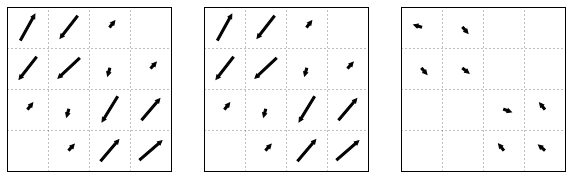

In [122]:
import matplotlib.pylab as plt
fig = plt.figure(figsize=(10,3))
U1.arrow_plot(fig.add_subplot(131, aspect=1))
U2.arrow_plot(fig.add_subplot(132, aspect=1))
(U1-U2).arrow_plot(fig.add_subplot(133, aspect=1))